In [1]:
import pandas as pd
import numpy as np
from scipy.spatial.transform import Rotation as R
from matplotlib import pyplot as plt

import uproot, uproot_methods
import uproot_methods.classes.TLorentzVector as TLorentzVector

In [2]:
bkgFile = pd.read_hdf('/home/btannenw/Desktop/ML/lhcOlympics2020/events_LHCO2020_backgroundMC_Pythia.h5', stop=400)
#blackBox1 = pd.read_hdf('/home/btannenw/Desktop/ML/lhcOlympics2020/events_LHCO2020_BlackBox1.h5', stop=400)

In [3]:
bkgFile

,0,1,2,3,4,5,6,7,8,9,...,2090,2091,2092,2093,2094,2095,2096,2097,2098,2099
0,3.587869,-2.323472,-2.597121,1.497173,-2.480994,-2.269457,0.848844,-2.465643,-2.096595,0.961511,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.921213,-0.745233,1.018857,0.689363,-0.642245,3.050711,1.999174,-0.343135,-0.322586,1.580572,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.580352,-2.412026,1.680236,0.429869,-0.778697,-1.453413,0.856914,-2.243512,0.217628,0.407344,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.579134,-0.243543,-2.561824,0.312690,-0.283086,-0.281626,0.775053,-2.062494,-1.598718,0.868891,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.644219,-2.457281,-2.670996,0.186128,-1.757650,2.719159,0.346987,-2.318233,-0.155036,0.501437,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,0.371261,-1.062192,-0.791878,1.772535,-2.302042,2.452436,4.420379,-0.683274,0.069763,3.542526,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
396,0.709062,-0.693257,-0.595142,8.466281,-0.360812,1.682917,1.232329,-0.274196,0.085934,485.987762,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
397,2.485312,-2.359157,-0.871838,0.496522,-2.396026,1.355003,0.592562,-0.861087,0.921106,0.567934,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
398,0.672370,-1.155408,-3.136519,0.574684,-0.174496,-0.110780,5.710929,-1.478994,-1.478113,2.002631,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
len(bkgFile)
b = list(bkgFile.iloc[0])
print(b[0:3], b[3:6], b[0:10])


[3.5878686904907227, -2.323472261428833, -2.597120761871338] [1.4971730709075928, -2.4809937477111816, -2.2694573402404785] [3.5878686904907227, -2.323472261428833, -2.597120761871338, 1.4971730709075928, -2.4809937477111816, -2.2694573402404785, 0.8488437533378601, -2.4656431674957275, -2.0965945720672607, 0.9615107178688049]


In [106]:
def returnTheta( _eta ):
    #return 180     - 2*np.arctan(np.exp(-1 * _eta))*360/np.pi  # degrees
    return np.pi/2 - 2*np.arctan(np.exp(-1 * _eta))            # radians

def returnEta( _theta ):
    return -1* np.log(np.tan((np.pi/2-_theta)/2))  # radians
    
def rotateEta( _eta, _theta):
    _thetaOriginal = returnTheta(_eta)
    
    print(_thetaOriginal, _theta)
    #_newTheta = (((_thetaOriginal - _theta)+np.pi) % (2*np.pi))-np.pi
    _newTheta = (((_thetaOriginal - _theta)) % (2*np.pi))
    
    return returnEta(_newTheta) 

def rotatePhi(_phi, _rotAngle):
    return (((_phi - _rotAngle)+np.pi) % (2*np.pi))-np.pi 

def getRotatedVectors( _lorentzVectors, _angle=0 , _axis=[1, 0, 0] ):
    """gets a list of lorentzVectors, an angle, and a rotation axis. spits back the rotated lorentzVectors"""
    
    _newLorentzVectors = []
    r = R.from_rotvec( _angle * np.array(_axis))   

    for _4vector in _lorentzVectors:
        _3vector = np.array([ _4vector.x, _4vector.y, _4vector.z ])
        #_3vector = 
        _3vector = _3vector.dot( r.as_matrix() )
        
        _newPt   = np.sqrt( _3vector[0]*_3vector[0] + _3vector[1]*_3vector[1] )
        _newEta  = _4vector.eta
        _newPhi  = np.arctan2( _3vector[1], _3vector[0] )
        _newMass2 = np.sqrt( _4vector.t*_4vector.t - _3vector.dot( _3vector ) )
        _newMass  = np.sqrt( _newMass2 )
        
        #print("old phi: {}, new phi: {}".format(_4vector.phi, _newPhi))
        if np.abs(_newMass - _4vector.mass) > 1e-2:
            print("!!!! bad new mass: {}, good old mass: {}".format(_newMass2, _4vector.mass))
            
        _new4vector = TLorentzVector.PtEtaPhiMassLorentzVector( _newPt, _newEta, _newPhi, 0)
        _newLorentzVectors.append( _new4vector )
        
    return _newLorentzVectors

In [107]:
# *** Make object with particles [pt, eta, phi] as elements and remove 0-pads
step=3
minPt=2
maxAbsEta = 2.5
newRows = []
#np.zeros([25,25])


for row in range(0, len(bkgFile)):
    _tempRow = []
    _currentEvent = list(bkgFile.iloc[row])
    for data in range(0, int(len(_currentEvent)/3) ):
        if _currentEvent[data*step] == 0:
            break
        else:
            if(_currentEvent[data*step] > minPt and np.abs(_currentEvent[data*step +1]) < maxAbsEta):
                _tempRow.append( _currentEvent[data*step: (data+1)*step] )
    
    newRows.append( _tempRow )

    if row > 20:
        break

726.0951538085938 726.0951538085938 726.0951538085938 0.24192193150520325 -2.5637898445129395


/usr/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in sqrt


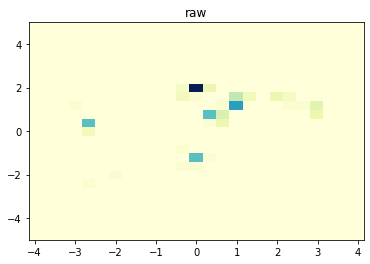

252.55770874023438 252.55770874023438 252.55770874023438 0.41146034002304077 -0.5638019442558289


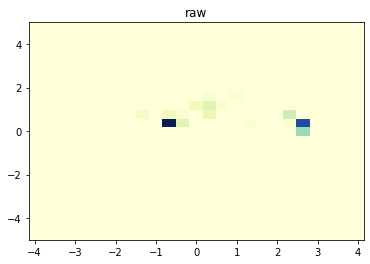

497.39813232421875 497.39813232421875 497.39813232421875 -0.8051890730857849 2.8467702865600586


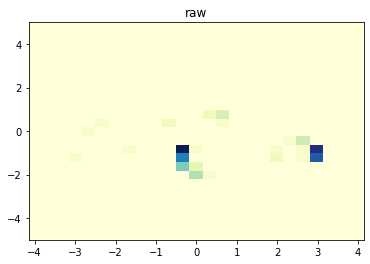

285.5962829589844 285.5962829589844 285.5962829589844 0.06891974061727524 -2.129371166229248


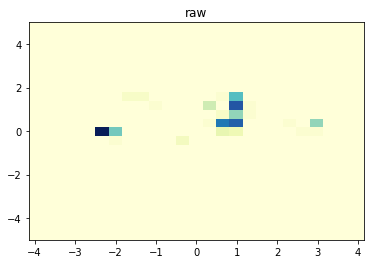

716.2669067382812 716.2669067382812 716.2669067382812 0.7971439957618713 0.3185913562774658


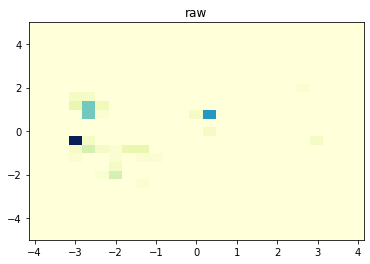

587.4020385742188 587.4020385742188 587.4020385742188 1.182598352432251 1.475293517112732


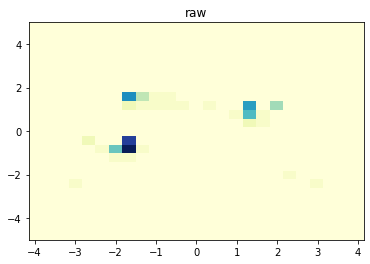

694.8456420898438 694.8456420898438 694.8456420898438 -0.28465959429740906 -0.8771829605102539


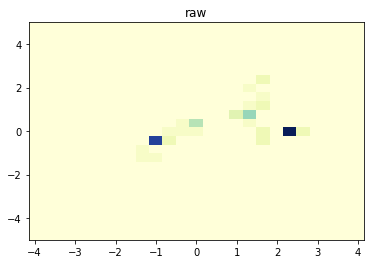

393.3050231933594 393.3050231933594 393.3050231933594 -0.2605723440647125 -0.9832208752632141


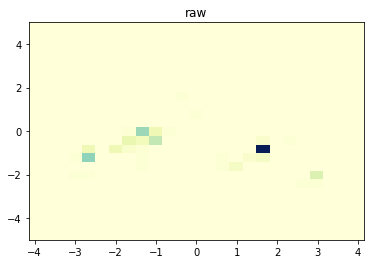

554.2276000976562 554.2276000976562 554.2276000976562 0.22918397188186646 -0.23635755479335785


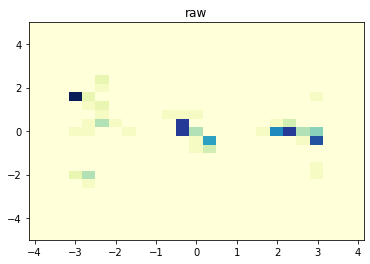

1146.9945068359375 1146.9945068359375 1146.9945068359375 -0.9522851705551147 -2.8269262313842773


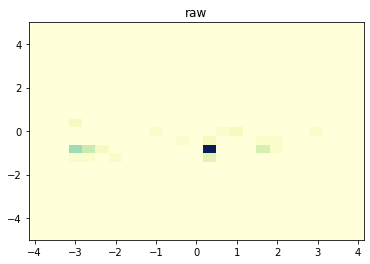

327.7366638183594 327.7366638183594 327.7366638183594 1.3857085704803467 -1.0058737993240356


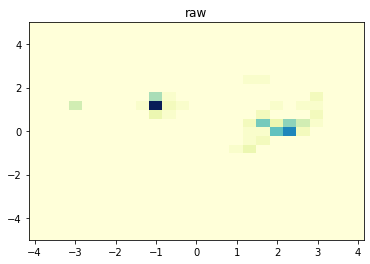

196.8775634765625 196.8775634765625 196.8775634765625 -0.17669843137264252 0.15698716044425964


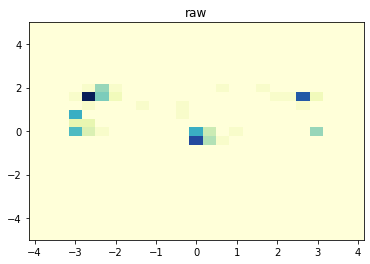

616.8617553710938 616.8617553710938 616.8617553710938 -0.17319750785827637 1.7203361988067627


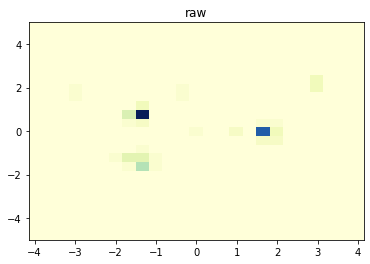

625.491455078125 625.491455078125 625.491455078125 -0.2452542930841446 3.038743257522583


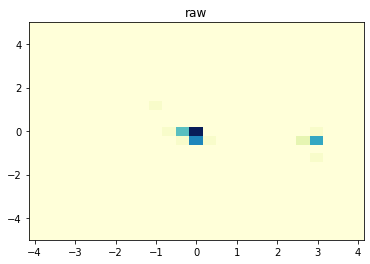

251.41558837890625 251.41558837890625 251.41558837890625 -0.16481414437294006 1.480612874031067


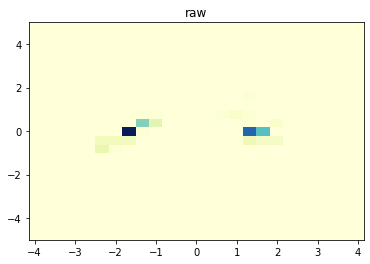

330.2690124511719 330.2690124511719 330.2690124511719 1.1613630056381226 -2.7705235481262207


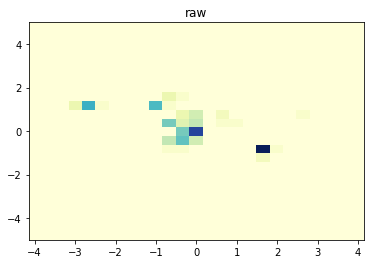

569.8797607421875 569.8797607421875 569.8797607421875 -0.12808994948863983 -0.8512922525405884


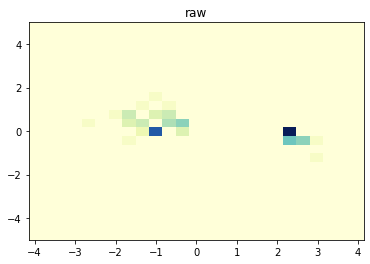

294.7197570800781 294.7197570800781 294.7197570800781 0.473289430141449 0.9060229063034058


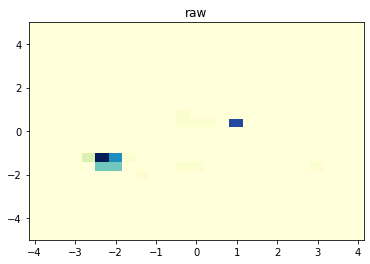

320.94622802734375 320.94622802734375 320.94622802734375 1.2275229692459106 0.9232115745544434


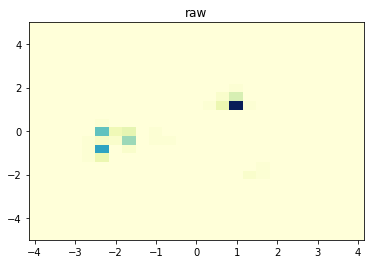

871.1630249023438 871.1630249023438 871.1630249023438 0.052126795053482056 -1.4742413759231567


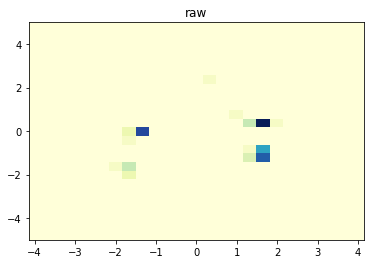

723.1995239257812 723.1995239257812 723.1995239257812 0.407236784696579 1.0064287185668945


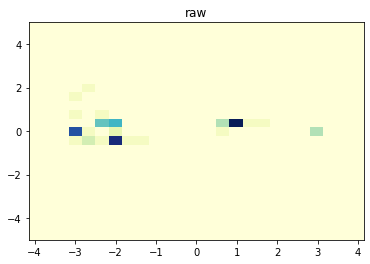

700.485595703125 700.485595703125 700.485595703125 0.823371171951294 -0.30640554428100586


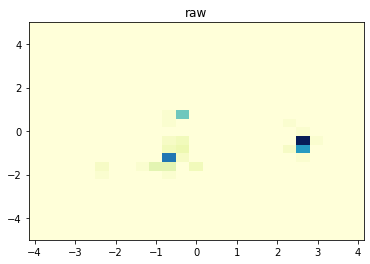

In [111]:

# *** Make some event-by-event image plots and also do translation to unified frame
allEta = []
allPhi = []
allPt  = []
allPtNormed  = []
allPhiTrans  = []
allPhiRot    = []
allEtaRot    = []

plotOpts = dict(bins=(25, 25), range=[[-1*np.pi-1, np.pi+1],[-5.0, 5.0]], cmap=plt.cm.YlGnBu)

for event in range(0, len(newRows)):
    #if event > 1:
    #    break
    
    _pt  = [ particle[0] for particle in newRows[event] ]
    _eta = [ particle[1] for particle in newRows[event] ]
    _phi = [ particle[2] for particle in newRows[event] ]
    _tlv = [ TLorentzVector.PtEtaPhiMassLorentzVector( particle[0], particle[1], particle[2], 0) for particle in newRows[event] ]
    
    _highestPtIndex = _pt.index(max(_pt))
    _hardestPhi     = _phi[_highestPtIndex]
    _hardestTheta   = returnTheta(_eta[_highestPtIndex])
    #_hardestPhi = np.pi/2

    ### rotate by phi
    _tlv_rotatedByPhi = getRotatedVectors( _tlv, _angle = _hardestPhi , _axis=[0, 0, 1] )
    _phi_rot = [ tlv.phi for tlv in _tlv_rotatedByPhi ]
     _tlv_rotatedByEta = getRotatedVectors( _tlv_rotatedByPhi, _angle = _hardestTheta , _axis=[1, 0, 0] )
    _eta_rot = [ tlv.eta for tlv in _tlv_rotatedByEta ]
  
    
    ###   
    _phi_trans = [ rotatePhi(p_phi, _hardestPhi) for p_phi in _phi ]
    _pt_normed = [ particle[0]/_pt[_highestPtIndex] for particle in newRows[event] ]
    
    #print(max(_pt), _pt[_highestPtIndex], _eta[_highestPtIndex], _phi[_highestPtIndex])
    print(max(_pt), _pt[_highestPtIndex], _tlv[_highestPtIndex].pt, _tlv[_highestPtIndex].eta, _tlv[_highestPtIndex].phi)
    
    
    allPt       += _pt 
    allPtNormed += _pt_normed
    allEta      += _eta 
    allEtaRot   += _eta_rot
    
    allPhi      += _phi
    allPhiTrans += _phi_trans
    allPhiRot   += _phi_rot
    
    #plt.hist2d( _phi, _eta, **plotOpts )
    #plt.title('raw')
    #plt.show()
    
    #plt.hist2d( _phi, _eta, weights=_pt, **plotOpts)
    #plt.title('pt weighted')
    #plt.show()
        
    #plt.hist2d( _phi_rot, _eta, weights=_pt, **plotOpts)
    #plt.title('pt weighted, rot in phi')
    #plt.show()

In [86]:
np.pi + (-2.597 - np.pi/2) + np.pi 

2.11538898038469

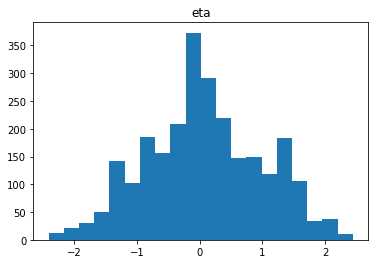

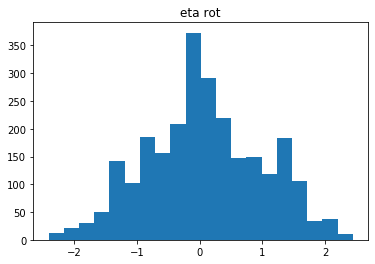

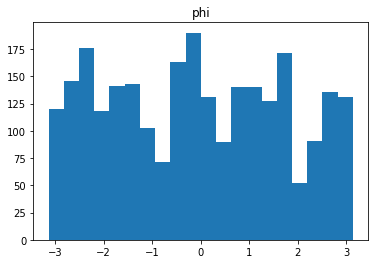

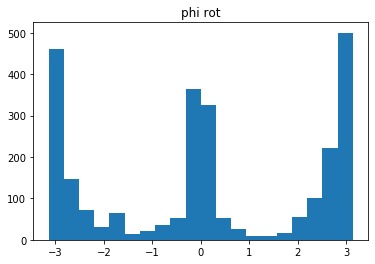

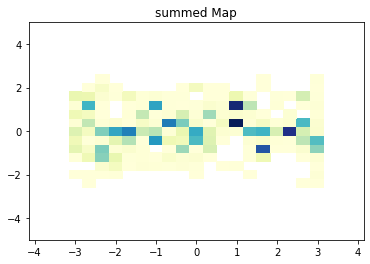

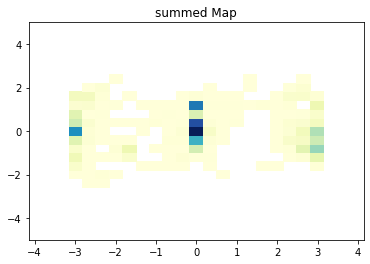

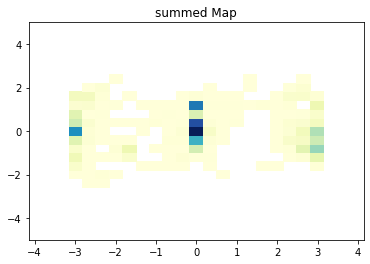

In [113]:
#plt.hist(allPt, bins=50)
#plt.title('pt')
#plt.show()
plt.hist(allEta, bins=20)
plt.title('eta')
plt.show()
plt.hist(allEtaRot, bins=20)
plt.title('eta rot')
plt.show()

plt.hist(allPhi, bins=20)
plt.title('phi')
plt.show()

plt.hist(allPhiRot, bins=20)
plt.title('phi rot')
plt.show()

plt.hist2d(allPhi, allEta, weights=allPtNormed, **plotOpts, cmin=.01)
plt.title('summed Map')
plt.show()
plt.hist2d(allPhiTrans, allEta, weights=allPtNormed, **plotOpts, cmin=.01)
plt.title('summed Map')
plt.show()
plt.hist2d(allPhiRot, allEtaRot, weights=allPtNormed, **plotOpts, cmin=.01)
plt.title('summed Map')
plt.show()

In [ ]:
eta = 1.5

In [346]:
def returnTheta( _eta ):
    #return 180     - 2*np.arctan(np.exp(-1 * _eta))*360/np.pi  # degrees
    return np.pi/2 - 2*np.arctan(np.exp(-1 * _eta))            # radians

def returnEta( _theta ):
    return -1* np.log(np.tan((np.pi/2-_theta)/2))  # radians
    
def rotateEta( _eta, _theta):
    _thetaOriginal = returnTheta(_eta)
    
    print(_thetaOriginal, _theta)
    #_newTheta = (((_thetaOriginal - _theta)+np.pi) % (2*np.pi))-np.pi
    _newTheta = (((_thetaOriginal - _theta)) % (2*np.pi))
    
    return returnEta(_newTheta) 

def rotatePhi(_phi, _rotAngle):
    return (((_phi - _rotAngle)+np.pi) % (2*np.pi))-np.pi 


theta1 = returnTheta(1.5)
theta2 = returnTheta(-0.5)
theta3 = returnTheta(0.0)
theta4 = returnTheta(2.5)
print(theta1, theta2, theta3, theta4)

eta1 = returnEta(theta1)
eta2 = returnEta(theta2)
eta3 = returnEta(theta3)
eta4 = returnEta(theta4)
print(eta1, eta2, eta3, eta4)

theta1_1 = rotateEta(0.0, np.pi)
#theta2 = theta*np.cos(theta)
print(theta1_1)

1.131728345250509 -0.48038107913372974 0.0 1.4069935689361537
1.4999999999999998 -0.5000000000000003 1.1102230246251565e-16 2.5
0.0 3.141592653589793
nan


/usr/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in log
  


In [293]:
returnTheta(-np.pi/2)

-1.1608753909688043

In [196]:
np.cos(0)

1.0

In [281]:
print(_tlv[6].pt, _tlv[6].energy, _tlv[6]) 

4.745270252227783 10.479161426573947 TLorentzVector(4.7453, -1.4297, -0.63138, 0)


In [285]:
_tlv[6].t

10.479161426573947

In [352]:
rotatePhi(-3*np.pi/4, np.pi/4)

-3.141592653589793

In [11]:
angle = np.pi / 1
print( np.cos(angle) + np.sin(angle), np.cos(angle) - np.sin(angle))

-0.9999999999999999 -1.0000000000000002


In [18]:
a = R.from_rotvec( [0,0, np.pi/2])
r = R.from_rotvec(np.pi/4 * np.array([0, 0, 1]))
r.as_matrix()

array([[ 0.70710678, -0.70710678,  0.        ],
       [ 0.70710678,  0.70710678,  0.        ],
       [ 0.        ,  0.        ,  1.        ]])

In [19]:
v= np.array([3, 0, 1])
vp = v.dot(r.as_matrix())
print(v.dot(r.as_matrix()), v.dot(v), vp.dot(vp))
#a.as_matrix()

[ 2.12132034 -2.12132034  1.        ] 10 10.0


In [20]:
type(np.pi/4)

float

In [27]:
np.arctan2( 0, -1 )

3.141592653589793

In [68]:
_tlv[0].phi

-1.0845133066177368

In [96]:
np.arctan2(_tlv[0].y, _tlv[0].x)

-1.0845133066177368